<h1 align="center">DL Assignment: Credit Card Fraud Detection (Binary Classification)</h1>

In [ ]:
import numpy as np
import pandas as pd

from keras import models
from keras import layers

import matplotlib.pyplot as plt

# Loading Data and Preprocessing

In [ ]:
credit_cards_df = pd.read_csv("./creditcard.csv")
credit_cards_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Checking for Missing Values

There are no missing values in the data.

In [ ]:
credit_cards_df.isna().any().any()

False

## Removing Duplicates

There are 1081 duplicate rows

In [ ]:
credit_cards_df[credit_cards_df.duplicated()].shape

(1081, 31)

Dropping the duplicates...

In [ ]:
credit_cards_df.drop_duplicates(inplace=True)

## Data Normalization and Vectorization

Minimum and Maximum values for each column

In [ ]:
data_stats = credit_cards_df.describe()
data_stats

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,-0.001441,0.000202,-0.000715,0.000603,0.000252,0.001043,0.001162,0.000170,0.001515,-0.000264,0.000187,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,1.076407,1.018720,0.994674,0.995430,0.952215,0.914894,0.873696,0.842507,0.837378,0.813379,0.769984,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,-24.588262,-4.797473,-18.683715,-5.791881,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-7.213527,-54.497720,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,-0.535578,-0.761649,-0.406198,-0.647862,-0.425732,-0.581452,-0.466860,-0.483928,-0.498014,-0.456289,-0.211469,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,-0.093237,-0.032306,0.139072,-0.012927,0.050209,0.049299,0.067119,-0.065867,-0.002142,0.003367,-0.062353,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,0.453619,0.739579,0.616976,0.663178,0.492336,0.650104,0.523512,0.398972,0.501956,0.458508,0.133207,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,23.745136,12.018913,7.848392,7.126883,10.526766,8.877742,17.315112,9.253526,5.041069,5.591971,39.420904,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


Values of Columns V1 through V28 have different ranges: we need to normalize them.

In [ ]:
credit_cards_df.loc[:, "V1": "V28"] = credit_cards_df.loc[:, "V1": "V28"].sub(
    credit_cards_df.describe().loc["mean", "V1": "V28"]
)
credit_cards_df.loc[:, "V1": "V28"] = credit_cards_df.loc[:, "V1": "V28"].div(
    credit_cards_df.describe().loc["std", "V1": "V28"]
)

Map "Time" values to the range [0, 1]

In [ ]:
credit_cards_df.loc[:, "Time"] = credit_cards_df.loc[:, "Time"].astype("float64") / np.max(credit_cards_df.loc[:, "Time"])

Convert "Class" column to float64 to make the data homogeneous

In [ ]:
credit_cards_df.loc[:, "Class"] = credit_cards_df.loc[:, "Class"].astype(np.float64)
credit_cards_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-0.701081,-0.041687,1.680098,0.976621,-0.247020,0.348012,0.193699,0.084434,0.333533,0.085688,-0.541661,-0.620390,-0.996548,-0.327050,1.603612,-0.539733,0.246646,0.028990,0.497010,0.326273,-0.024777,0.383483,-0.177444,0.110157,0.247058,-0.392621,0.333032,-0.065849,149.62,0.0
1,0.000000,0.608791,0.164137,0.109279,0.318997,0.042258,-0.060980,-0.065656,0.072903,-0.231703,-0.153784,1.582893,1.071657,0.490734,-0.151252,0.693540,0.529652,-0.136467,-0.220780,-0.178907,-0.089963,-0.311371,-0.881453,0.162080,-0.561502,0.321175,0.260853,-0.027154,0.043219,2.69,0.0
2,0.000006,-0.700335,-0.811335,1.174268,0.270648,-0.366756,1.352652,0.643222,0.210788,-1.381167,0.194242,0.612827,0.067156,0.719980,-0.174539,2.562945,-3.309211,1.317258,-0.146737,-2.780492,0.681563,0.343094,1.065067,1.457769,-1.138482,-0.628159,-0.288860,-0.144325,-0.183824,378.66,0.0
3,0.000006,-0.499064,-0.109972,1.187381,-0.608354,-0.008814,0.937243,0.192079,0.320842,-1.264662,-0.049713,-0.222523,0.179901,0.509482,-0.302638,-0.691295,-1.214162,-0.812174,2.345728,-1.515110,-0.270428,-0.149093,0.007299,-0.305464,-1.941443,1.242485,-0.460693,0.154039,0.185687,123.50,0.0
4,0.000012,-0.597605,0.535538,1.025468,0.287092,-0.297036,0.072872,0.481516,-0.228724,0.747915,0.700957,-0.807920,0.541796,1.351425,-1.176123,0.190272,-0.518042,-0.281545,-0.047422,0.988164,0.530342,-0.012516,1.101778,-0.220708,0.232904,-0.394799,1.041676,0.550000,0.654233,69.99,0.0


In [ ]:
credit_cards_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,2.837260e+05,283726.000000,283726.000000
mean,0.548701,-2.163896e-15,1.723077e-16,3.161866e-15,-9.771857e-16,3.252123e-15,-2.658013e-16,1.479581e-15,3.017235e-16,1.449294e-15,4.549020e-16,1.460529e-15,3.604078e-16,-1.036357e-15,-8.759689e-16,4.328131e-15,2.161332e-17,3.248840e-16,7.056002e-16,1.547330e-16,3.924582e-16,3.193375e-16,-1.630733e-15,-6.421451e-16,-2.211837e-17,-2.232311e-15,-1.248478e-16,-1.893228e-16,-2.805617e-17,88.472687,0.001667
std,0.274787,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,250.399437,0.040796
min,0.000000,-2.895928e+01,-4.415586e+01,-3.203273e+01,-4.016595e+00,-8.260309e+01,-1.964019e+01,-3.548124e+01,-6.209710e+01,-1.226158e+01,-2.284156e+01,-4.709512e+00,-1.878303e+01,-5.819080e+00,-2.017882e+01,-4.918591e+00,-1.617383e+01,-2.986677e+01,-1.134525e+01,-8.868273e+00,-7.077795e+01,-4.811377e+01,-1.508953e+01,-7.184185e+01,-4.684141e+00,-1.975204e+01,-5.403348e+00,-5.702537e+01,-4.704079e+01,0.000000,0.000000
25%,0.313699,-4.732321e-01,-3.620482e-01,-5.907774e-01,-5.990509e-01,-5.022899e-01,-5.765250e-01,-4.515162e-01,-1.763905e-01,-5.866079e-01,-4.962224e-01,-7.478512e-01,-4.076539e-01,-6.514428e-01,-4.473619e-01,-6.366802e-01,-5.356800e-01,-5.745917e-01,-5.965403e-01,-5.606549e-01,-2.748841e-01,-3.148658e-01,-7.489950e-01,-2.595815e-01,-5.856209e-01,-6.086735e-01,-6.781679e-01,-1.829563e-01,-1.626860e-01,5.600000,0.000000
50%,0.490141,7.426443e-03,4.134560e-02,1.182155e-01,-1.363451e-02,-4.015602e-02,-2.057376e-01,3.181553e-02,1.929716e-02,-4.655390e-02,-8.527981e-02,-3.191033e-02,1.405352e-01,-1.359249e-02,5.246332e-02,5.274494e-02,7.549205e-02,-7.838163e-02,-4.367113e-03,4.464522e-03,-8.122327e-02,-4.015696e-02,9.233205e-03,-1.820860e-02,6.737075e-02,3.167710e-02,-1.085380e-01,-7.187396e-04,3.274214e-02,22.000000,0.000000
75%,0.806160,6.725529e-01,4.885020e-01,6.796309e-01,5.251179e-01,4.432729e-01,2.987630e-01,4.632157e-01,2.769661e-01,5.454835e-01,4.227576e-01,7.257905e-01,6.209984e-01,6.656170e-01,5.167774e-01,7.094391e-01,5.978617e-01,4.733508e-01,5.976283e-01,5.640328e-01,1.727567e-01,2.577176e-01,7.290869e-01,2.365716e-01,7.257346e-01,6.732273e-01,4.981027e-01,2.260177e-01,2.369588e-01,77.510000,0.000000
max,1.000000,1.257177e+00,1.339760e+01,6.217974e+00,1.193502e+01,2.527206e+01,5.503497e+01,9.822533e+01,1.696958e+01,1.423706e+01,2.206096e+01,1.179785e+01,7.891132e+00,7.158999e+00,1.105476e+01,9.702438e+00,1.981690e+01,1.098312e+01,6.018258e+00,6.875317e+00,5.119678e+01,3.757820e+01,1.449603e+01,3.612013e+01,7.569572e+00,1.442734e+01,7.296286e+00,7.987599e+01,1.031845e+02,25691.160000,1.000000


In [ ]:
credit_cards_df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class     float64
dtype: object

## Separating Data into Training and Test Datasets

The number of fraudulent transactions is very small.

In [ ]:
credit_cards_df["Class"].sum()

473.0

Let's separate fraudulent and legit transactions

In [ ]:
data_fraudulent = credit_cards_df.loc[credit_cards_df["Class"] == 1, :]
data_not_fraudulent = credit_cards_df.loc[credit_cards_df["Class"] == 0, :]

Combine 50% of the fraudulent and 50% of the legit transactions to make our training dataset.

In [ ]:
train_data = np.vstack((
    data_fraudulent[: int(data_fraudulent.shape[0] * 0.5)],
    data_not_fraudulent[: int(data_not_fraudulent.shape[0] * 0.5)],
))
np.random.shuffle(train_data)

Combine 20% of the fraudulent and 20% of the legit transactions to make our validation dataset.

In [ ]:
val_data = np.vstack((
    data_fraudulent[int(data_fraudulent.shape[0] * 0.5) : int(data_fraudulent.shape[0] * 0.7)],
    data_not_fraudulent[int(data_not_fraudulent.shape[0] * 0.5) : int(data_not_fraudulent.shape[0] * 0.7)]
))
np.random.shuffle(val_data)

Combine 30% of the fraudulent and 30% of the legit transactions to make our test dataset.

In [ ]:
test_data = np.vstack((
    data_fraudulent[int(data_fraudulent.shape[0] * 0.7) :],
    data_not_fraudulent[int(data_not_fraudulent.shape[0] * 0.7) :]
))
np.random.shuffle(test_data)

## Separating Training and Testing Datasets into Samples and Labels Tensors

Training dataset excluding the data for validation (50% of total samples)

In [ ]:
x_train_partial = train_data[:, :-1]
print("x_train_partial.shape = ", x_train_partial.shape)
print("x_train_partial.dtype = ", x_train_partial.dtype)

x_train_partial.shape =  (141862, 30)
x_train_partial.dtype =  float64


In [ ]:
y_train_partial = train_data[:, -1]
print("y_train_partial.shape = ", y_train_partial.shape)
print("y_train_partial.dtype = ", y_train_partial.dtype)

y_train_partial.shape =  (141862,)
y_train_partial.dtype =  float64


Validation dataset (20% of total samples)

In [ ]:
x_val = val_data[:, :-1]
print("x_val.shape = ", x_val.shape)
print("x_val.dtype = ", x_val.dtype)

x_val.shape =  (56746, 30)
x_val.dtype =  float64


In [ ]:
y_val = val_data[:, -1]
print("y_val.shape = ", y_val.shape)
print("y_val.dtype = ", y_val.dtype)

y_val.shape =  (56746,)
y_val.dtype =  float64


Complete training dataset, including the validation dataset (70% of total samples)

In [ ]:
x_train = np.vstack((x_train_partial, x_val))
print("x_train.shape = ", x_train.shape)
print("x_train.dtype = ", x_train.dtype)

x_train.shape =  (198608, 30)
x_train.dtype =  float64


In [ ]:
y_train = np.hstack((y_train_partial, y_val))
print("y_train.shape = ", y_train.shape)
print("y_train.dtype = ", y_train.dtype)

y_train.shape =  (198608,)
y_train.dtype =  float64


Test dataset (30% of total samples)

In [ ]:
x_test = test_data[:, :-1]
print("x_test.shape = ", x_test.shape)
print("x_test.dtype = ", x_test.dtype)

x_test.shape =  (85118, 30)
x_test.dtype =  float64


In [ ]:
y_test = test_data[:, -1]
print("y_test.shape = ", y_test.shape)
print("y_test.dtype = ", y_test.dtype)

y_test.shape =  (85118,)
y_test.dtype =  float64


# Building the Network

First let us build a model according to the instructions in the assignment

In [ ]:
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=(30,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(6, activation='relu'))

In [ ]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Training and Validating the Model

In [ ]:
history = model.fit(
    x_train_partial,
    y_train_partial,
    batch_size=512,
    epochs=100,
    validation_data=(x_val, y_val)
)

Epoch 1/100
278/278 [==============================] - 1s 3ms/step - loss: 1.2514 - accuracy: 0.4910 - val_loss: 0.0221 - val_accuracy: 0.9965
Epoch 2/100
278/278 [==============================] - 1s 2ms/step - loss: 0.0213 - accuracy: 0.9973 - val_loss: 0.0206 - val_accuracy: 0.9972
Epoch 3/100
278/278 [==============================] - 1s 2ms/step - loss: 0.0207 - accuracy: 0.9976 - val_loss: 0.0198 - val_accuracy: 0.9977
Epoch 4/100
278/278 [==============================] - 1s 2ms/step - loss: 0.0174 - accuracy: 0.9980 - val_loss: 0.0194 - val_accuracy: 0.9977
Epoch 5/100
278/278 [==============================] - 1s 2ms/step - loss: 0.0204 - accuracy: 0.9978 - val_loss: 0.0193 - val_accuracy: 0.9975
Epoch 6/100
278/278 [==============================] - 1s 2ms/step - loss: 0.0192 - accuracy: 0.9979 - val_loss: 0.0190 - val_accuracy: 0.9955
Epoch 7/100
278/278 [==============================] - 1s 2ms/step - loss: 0.0193 - accuracy: 0.9978 - val_loss: 0.0190 - val_accuracy: 0.9978

Now, let's examine the performance of our model on the validation data after each epoch.

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

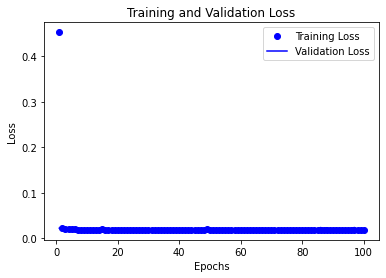

In [ ]:
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

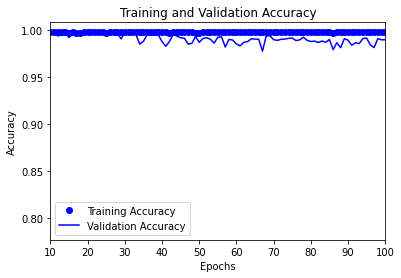

In [ ]:
plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.xlim(10, 100)
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The model starts somewhat overfitting after 40 epochs

# Evaluate the Model

Now, let's retrain our model from scratch for 40 epochs only on all of the training data.

In [ ]:
model = models.Sequential()
model.add(layers.Dense(10, activation='relu', input_shape=(30,)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(6, activation='relu'))

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=40
)

Epoch 1/40
388/388 [==============================] - 2s 2ms/step - loss: 4.0978 - accuracy: 0.6942
Epoch 2/40
388/388 [==============================] - 1s 2ms/step - loss: 0.0213 - accuracy: 0.9973
Epoch 3/40
388/388 [==============================] - 1s 2ms/step - loss: 0.0210 - accuracy: 0.9982
Epoch 4/40
388/388 [==============================] - 1s 2ms/step - loss: 0.0201 - accuracy: 0.9982
Epoch 5/40
388/388 [==============================] - 1s 2ms/step - loss: 0.0194 - accuracy: 0.9982
Epoch 6/40
388/388 [==============================] - 1s 2ms/step - loss: 0.0195 - accuracy: 0.9981
Epoch 7/40
388/388 [==============================] - 1s 2ms/step - loss: 0.0191 - accuracy: 0.9979
Epoch 8/40
388/388 [==============================] - 1s 2ms/step - loss: 0.0188 - accuracy: 0.9981
Epoch 9/40
388/388 [==============================] - 1s 2ms/step - loss: 0.0173 - accuracy: 0.9983
Epoch 10/40
388/388 [==============================] - 1s 2ms/step - loss: 0.0178 - accuracy: 0.9981

In [ ]:
result = model.evaluate(x_test, y_test)
print("Model Accuracy for Test Data: {acc:.2f}%".format(acc=result[1]*100))

2660/2660 [==============================] - 3s 1ms/step - loss: 0.0135 - accuracy: 0.9987
Model Accuracy for Test Data: 99.87%


# Another Approach

Although the model is performing well; however, there are some problems in the model.

First of all, we can improve the overfitting issue by reducing the size of layers.

Second, the last layer should have the activation function of "sigmoid" as we want our model to output a prediction value (between 0 and 1).

In [ ]:
model2 = models.Sequential()
model2.add(layers.Dense(2, activation='relu', input_shape=(30,)))
model2.add(layers.Dense(2, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model2.fit(
    x_train_partial,
    y_train_partial,
    batch_size=512,
    epochs=1000,
    validation_data=(x_val, y_val)
)

Epoch 1/1000
278/278 [==============================] - 2s 3ms/step - loss: 0.2101 - accuracy: 0.9527 - val_loss: 0.1076 - val_accuracy: 0.9979
Epoch 2/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0743 - accuracy: 0.9987 - val_loss: 0.0651 - val_accuracy: 0.9988
Epoch 3/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0451 - accuracy: 0.9987 - val_loss: 0.0410 - val_accuracy: 0.9988
Epoch 4/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0431 - accuracy: 0.9987 - val_loss: 0.0271 - val_accuracy: 0.9988
Epoch 5/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0300 - accuracy: 0.9989 - val_loss: 0.0183 - val_accuracy: 0.9988
Epoch 6/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0312 - accuracy: 0.9987 - val_loss: 0.0133 - val_accuracy: 0.9989
Epoch 7/1000
278/278 [==============================] - 1s 2ms/step - loss: 0.0130 - accuracy: 0.9989 - val_loss: 0.0105 - val_accuracy:

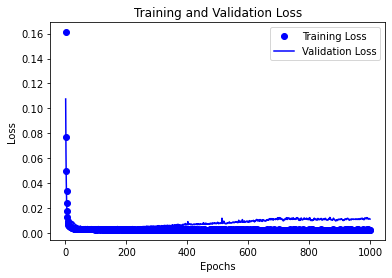

In [ ]:
history_dict = history.history
history_dict.keys()

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.clf()
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

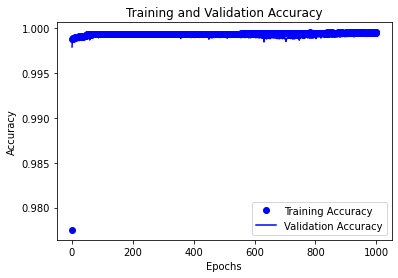

In [ ]:
plt.clf()
plt.plot(epochs, acc_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Now, our model starts overfitting after 400 epochs. The validation accuracy has also improved somewhat.

# Final Evaluation

In [ ]:
model3 = models.Sequential()
model3.add(layers.Dense(2, activation='relu', input_shape=(30,)))
model3.add(layers.Dense(2, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model3.fit(
    x_train,
    y_train,
    batch_size=512,
    epochs=400,
    verbose=False
)

In [ ]:
result = model3.evaluate(x_test, y_test)
result

2660/2660 [==============================] - 3s 1ms/step - loss: 0.0052 - accuracy: 0.9994


[0.005246598739176989, 0.99943608045578]

# Final Accuracy

In [ ]:
print("Model Accuracy for Test Data: {acc:.2f}%".format(acc=result[1]*100))

Model Accuracy for Test Data: 99.94%
